<a href="https://colab.research.google.com/github/seokhee516/kaggle-practice/blob/main/Binary%20classification/Home%20Credit%20Default%20Risk/Introduction%20to%20Manual%20Feature%20Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction : Manual Feature Engineering
- application 데이터만 사용했을 때, 리더보드 0.74를 기록하였다.
- 이 스코어를 뛰어넘기 위해 다른 데이터프레임을 활용하여 정보를 더 모으고자 한다.
- 본 커널에서는 bureau 및 breau_balance 데이터를 살펴본다.
- bureau: Home Credit에 제출된 고객(Cient)의 다른 금융기관에서의 과거 대출 기록(각각의 대출 기록은 각 열로 정리되어 있다.)
- bureau_balance: 과거 대출들의 월별 데이터(각 월별 데이터는 각각의 열로 정리되어있다.


- **수작업(Manual) Feature Engineering은 지루한 과정일 수 있다**.
- 또한 도메인 지식을 필요로 하기도 한다.
- 대출 및 채무 불이행의 주된 원인에 대한 지식을 갖추는데 한계가 있기 때문에 최종 학습용 데이터프레임에서 가능한 많은 정보를 얻는데 주안점을 두었다.
- 즉, 이 커널은 어떤 Feature들이 중요한지를 결정하는 것에 있어서, 사람보다 모델이 고르도록하는 접근방식을 취한다.
- 기본적으로 이러한 접근방식에서는 최대한 많은 Feature들을 만들고, 모델은 이러한 Feature들을 전부 활용한다.
- 추후 모델에서 얻어진 Feature Importance나 PCA를 통해 Feature Reduction을 할 수 있다.

- 수작업(Manual) Feature Engineering의 각 과정은 많은 양의 Pandas 코드와 약간의 인내심, 특히 데이터 처리에 있어서 많은 인내심을 필요로 한다. 
- 비록 자동화된 Feature Engineering 도구들이 활용되기 시작했지만, 당분간 Feature Engineering은 여전히 전처리 작업을 필요로 한다.

In [2]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

# 예시: 고객의 이전 대출 수량 파악(Counts of a client's previous loans) 
Manual feature engineering의 보편적인 방법을 설명하기 위해, 먼저 고객의 과거 타 금융기관에서의 대출 수량을 간단히 파악하고자 함. 이 과정은 커널에서 반복적으로 사용되는 아래의 Pandas 명령어들을 포함한다.
- groupby: Column 값에 따라 데이터프레임을 그룹화. 이 과정에서는 SK_ID_CURR Column긔 값에 따라 고객별로 데이터프레임을 그룹화
- agg: 그룹화된 데이터의 평균 등을 계산.'grouped_df.mean()'을 통해 직접 평균을 계산 하거나 agg 명령어와 리스트를 활용하여 평균, 최대값, 최소값, 합계 등을 계산 (grouped_df.agg([mean, max, min, sum])
- merge: 집계된(aggregated) 값을 해당 고객과 매칭. SK_ID_CURR을 활용하여 집계된 값을 원본 트레이닝 데이터로 병합하고, 해당값이 없을 경우에는 NaN 값을 입력

또한 rename 명령어를 통해 Column을 dict를 활용하여 변경한다. 이러한 방식은 생성된 변수들을 계속해서 추적하는데 유용하다.

이러한 과정이 길게 느껴질 수도 있기 때문에, 추후 이러한 과정을 대신 해줄 함수를 작성할 예정이다. 우선 수작업으로 시행하는 과정을 살펴보자.

In [3]:
!pip install gcsfs

     |████████████████████████████████| 125 kB 11.7 MB/s 
     |████████████████████████████████| 1.3 MB 60.4 MB/s 
     |████████████████████████████████| 160 kB 56.4 MB/s 
     |████████████████████████████████| 271 kB 57.2 MB/s 


In [4]:
GCS_DS_PATH = "gs://kds-d0a70a4ad71e03ff9b29989a414b7a65cce86b61c82476461cdc1bb3"
bureau = pd.read_csv(GCS_DS_PATH+'/bureau.csv')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [5]:
# 고객 id(SK_ID_CURR)를 기준으로 groupby를 실행, 이전 대출 갯수를 파악하고, Column 이름을 변경
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns={
    'SK_ID_BUREAU': 'previous_loan_counts'})
previous_loan_counts.head()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [6]:
# 훈련용 데이터프레임과 병합(Join)
train = pd.read_csv(GCS_DS_PATH+'/application_train.csv')
train = train.merge(previous_loan_counts, on='SK_ID_CURR', how='left')

#NaN값에 0을 대입
train['previous_loan_counts'] = train['previous_loan_counts'].fillna(0)
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,previous_loan_counts
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,8.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


우측 끝에 previous_loan_counts가 생성되었다.

# R Value를 활용한 변수 유용성 평가(Assessing Usefulness of New Variable with r value)
새롭게 생성된 column의 변수들이 유용한지 판단하기 위해 목표값(target)과 해당 변수 간의 피어슨 상관계수(Pearson Correlation Coefficient, r-value)를 계산
- 두 변수 사이의 선형관계는 -1~1 사이의 값으로 표현
- r-value가 변수의 유용성을 평가하기 위한 최선의 방식은 아니지만, 머신러닝 모델을 발전시키는데 효과가 있을지 대략적인 정보를 줄 수 있다.
- 목표값에 대한 r-value가 커질 수록 해당 변수가 목표값에 영향을 끼칠 가능성이 높아진다.
- 그러므로 목표값에 대해 가장 큰 r-value의 절대값을 가지는 변수를 찾고자 한다.
- 또한 우리는 커널밀도추정그래프(KDE plot)을 활용하여 목표값과의 상관관계를 시각적으로 살펴볼 것이다.


**커널밀도추정그래프(Kernel Density Estimate Plots)**
- 커널밀도추정그래프는 단일 변수의 분포를 보여준다.(히스토그램을 부드럽게한(smoothed)것으로 생각해보면 될 것이다.)
- 범주형 변수(Categorical Variable)의 값 차이에 따른 분포의 차이를 보기 위해, 카테고리에 따라 색을 다르게 칠하도록 함
- 예를 들어 Target 값이 0인지 1인지에 따라 색을 다르게 칠한 previous_loan_count의 커널밀도추정그래프를 그릴 수 있다.
- 이러한 그래프는 대출을 상환한 그룹(Target==0)과 그렇지 못한 그룹(Target==1)의 분포의 차이점을 보여줄 것이다.
- 이는 변수들이 머신러닝 모델과 관련성을 가지는 지를 보여줄 수 있는 지표로 활용될 수 있다.



In [7]:
# 변수의 분포에 대한 그래프 target값에 따라 색을 달리하여 작성
def kde_target(var_name, df):
    '''
    Args
    
    input:
    
    var_name = str, 변수가 되는 Column
    df : DataFrame, 대상 데이터프레임
    
    
    return: None
    
    '''
    
    # 새롭게 생성된 변수와 target간의 상관계수를 계산
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # 대출의 상환한 그룹과 그렇지 않은 그룹의 중간값(median)계산
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.loc[df['TARGET']==0,var_name].median()
    avg_not_repaid = df.loc[df['TARGET']==1,var_name].median()
    
    plt.figure(figsize = (12,6))
    
    # target값에 따라 색을 달리하여 그래프 작성
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df['TARGET']==0,var_name],label = 'TARGET == 0')
    sns.kdeplot(df.loc[df['TARGET']==1,var_name],label = 'TARGET == 1')
    
    # 그래프 라벨링
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # 상관계수 출력
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    
    # 중간값 출력
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

- ix 메서드 loc 로 변경
- Random Forest 및 Gradient Boosting Machine에 의해 가장 중요한 변수로 판명된 EXT_SOURCE_3를 활용하여 테스트하도록 한다.

The correlation between EXT_SOURCE_3 and the TARGET is -0.1789
Median value for loan that was not repaid = 0.3791
Median value for loan that was repaid =     0.5460


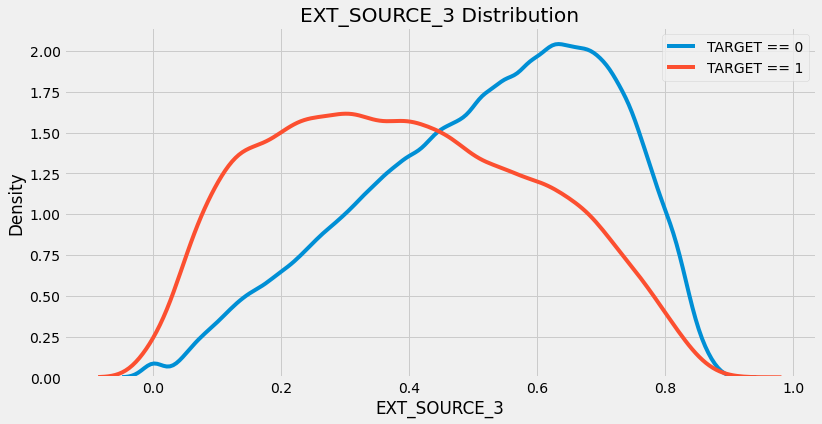

In [8]:
kde_target('EXT_SOURCE_3',train)

방금 새롭게 만들었던, previous_loan_counts를 살펴보도록 하겠습니다
- 예시 커널과 다름!!

The correlation between previous_loan_counts and the TARGET is -0.0100
Median value for loan that was not repaid = 3.0000
Median value for loan that was repaid =     4.0000


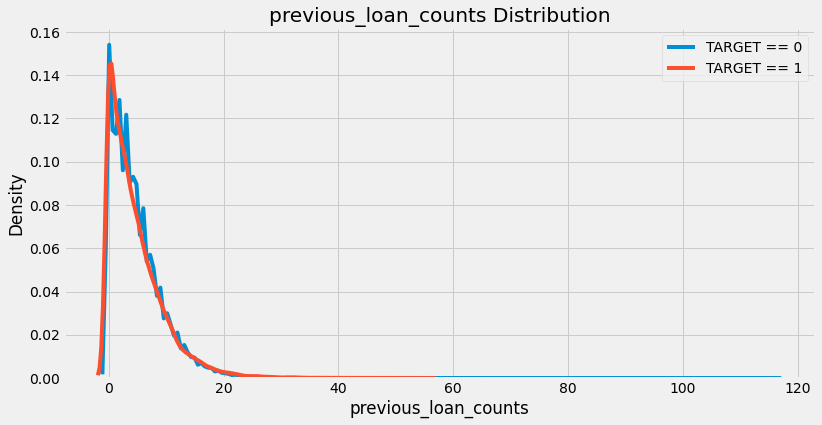

In [9]:
kde_target('previous_loan_counts',train)

이를 통해 새롭게 생성된 변수 (previous_loan_counts Distribution)가 별로 중요하지 않음을 알 수 있다.
- 상관계수가 너무 작음
- target 값에 따른 분포의 차이도 거의 없다.

이제 bureau 데이터프레임으로부터 몇개의 변수들을 새롭게 생성할 것
- bureau 데이터프레임의 모든 수치 데이터 Column(numeric column)들로부터 평균, 최소, 최대값을 가져올 예정

# 수치 데이터의 대표값들을 계산(Aggregating Numeric Columns)
- bureau 데이터 프레임 안의 수치 데이터를 활용하기 위해, 모든 수치 데이터 Column의 대표값들을 계산할 것
- 이를 위해 고객 ID 별로 그룹화를 수행하고, 그룹화된 데이터프레임의 대표값들을 agg를 통해 구한 뒤, 결과를 훈련 데이터셋과 병합한다.
- agg 함수는 오직 수치 데이터행들의 유효한 대표값들을 계산하는 역할을 수행한다
- mean, max, min, sum 함수를 기본으로 사용
- 상황에 따라 생략

In [10]:
# 고객 id에 따라 데이터프레임을 그룹화하고, 대표값들을 계산
bureau_agg = bureau.drop(columns=['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index=False).agg(['count','mean','max','min','sum']).reset_index()
bureau_agg.head()

SK_ID_CURR DAYS_CREDIT                    ...  AMT_ANNUITY                       
                   count         mean  max  ...         mean      max  min      sum
0     100001           7  -735.000000  -49  ...  3545.357143  10822.5  0.0  24817.5
1     100002           8  -874.000000 -103  ...     0.000000      0.0  0.0      0.0
2     100003           4 -1400.750000 -606  ...          NaN      NaN  NaN      0.0
3     100004           2  -867.000000 -408  ...          NaN      NaN  NaN      0.0
4     100005           3  -190.666667  -62  ...  1420.500000   4261.5  0.0   4261.5

[5 rows x 61 columns]

생성된 column들에 대해 새롭게 이름을 적어주는 것이 좋다.  
- 밑의 코드들은 원본 데이터의 Colummn에 대표값들의 종류들을 추가적으로 기입해주는 역할을 수행한다. 여기서는 Milti-Level index 데이터프레임을 작업의 대상으로 한다.
- 이러한 부분은 혼동을 줄 수 있고, 작업하기 어렵기 때문에, **single-level index**로 최대한 빠르게 변환함

In [11]:
# Column 리스트를 생성
columns = ['SK_ID_CURR']

# 변수에 따라 반복문을 실행
for var in bureau_agg.columns.levels[0]:
  
  # id column은 생략
  if var != 'SK_ID_CURR':
    
    # 대표값의 종류에 따라 반복문을 생성
    for stat in bureau_agg.columns.levels[1][:-1]:

      # 변수 및 대표값의 종류에 따라 새로운 column name을 생성
        columns.append('bureau_%s_%s' % (var,stat))

In [12]:
# 생성된 list를 데이터프레임의 column name으로 지정
bureau_agg.columns = columns
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_count,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_DAYS_ENDDATE_FACT_count,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_ENDDATE_FACT_min,bureau_DAYS_ENDDATE_FACT_sum,bureau_AMT_CREDIT_MAX_OVERDUE_count,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_max,bureau_AMT_CREDIT_MAX_OVERDUE_min,bureau_AMT_CREDIT_MAX_OVERDUE_sum,bureau_CNT_CREDIT_PROLONG_count,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_min,bureau_CNT_CREDIT_PROLONG_sum,bureau_AMT_CREDIT_SUM_count,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_LIMIT_count,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_AMT_CREDIT_SUM_LIMIT_min,bureau_AMT_CREDIT_SUM_LIMIT_sum,bureau_AMT_CREDIT_SUM_OVERDUE_count,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,0,7,82.428571,1778.0,-1329.0,577.0,4,-825.500000,-544.0,-1328.0,-3302.0,0,NaN,NaN,NaN,0.000,7,0.0,0,0,0,7,207623.571429,378000.0,85500.0,1453365.000,7,85240.928571,373239.0,0.0,596686.5,6,0.00000,0.000,0.0,0.000,7,0.0,0.0,0.0,0.0,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,0,6,-349.000000,780.0,-1072.0,-2094.0,6,-697.500000,-36.0,-1185.0,-4185.0,5,1681.029,5043.645,0.0,8405.145,8,0.0,0,0,0,8,108131.945625,450000.0,0.0,865055.565,5,49156.200000,245781.0,0.0,245781.0,4,7997.14125,31988.565,0.0,31988.565,8,0.0,0.0,0.0,0.0,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,0,4,-544.500000,1216.0,-2434.0,-2178.0,3,-1097.333333,-540.0,-2131.0,-3292.0,4,0.000,0.000,0.0,0.000,4,0.0,0,0,0,4,254350.125000,810000.0,22248.0,1017400.500,4,0.000000,0.0,0.0,0.0,4,202500.00000,810000.000,0.0,810000.000,4,0.0,0.0,0.0,0.0,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,0,2,-488.500000,-382.0,-595.0,-977.0,2,-532.500000,-382.0,-683.0,-1065.0,1,0.000,0.000,0.0,0.000,2,0.0,0,0,0,2,94518.900000,94537.8,94500.0,189037.800,2,0.000000,0.0,0.0,0.0,2,0.00000,0.000,0.0,0.000,2,0.0,0.0,0.0,0.0,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,0,3,439.333333,1324.0,-128.0,1318.0,1,-123.000000,-123.0,-123.0,-123.0,1,0.000,0.000,0.0,0.000,3,0.0,0,0,0,3,219042.000000,568800.0,29826.0,657126.000,3,189469.500000,543087.0,0.0,568408.5,3,0.00000,0.000,0.0,0.000,3,0.0,0.0,0.0,0.0,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


In [13]:
# 훈련데이터와 병합
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,bureau_AMT_CREDIT_MAX_OVERDUE_count,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_max,bureau_AMT_CREDIT_MAX_OVERDUE_min,bureau_AMT_CREDIT_MAX_OVERDUE_sum,bureau_CNT_CREDIT_PROLONG_count,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_min,bureau_CNT_CREDIT_PROLONG_sum,bureau_AMT_CREDIT_SUM_count,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_LIMIT_count,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_AMT_CREDIT_SUM_LIMIT_min,bureau_AMT_CREDIT_SUM_LIMIT_sum,bureau_AMT_CREDIT_SUM_OVERDUE_count,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,5.0,1681.029,5043.645,0.0,8405.145,8.0,0.0,0.0,0.0,0.0,8.0,108131.945625,450000.0,0.0,865055.565,5.0,49156.2,245781.0,0.0,245781.0,4.0,7997.14125,31988.565,0.0,31988.565,8.0,0.0,0.0,0.0,0.0,8.0,-499.875,-7.0,-1185.0,-3999.0,7.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,4.0,0.000,0.000,0.0,0.000,4.0,0.0,0.0,0.0,0.0,4.0,254350.125000,810000.0,22248.0,1017400.500,4.0,0.0,0.0,0.0,0.0,4.0,202500.00000,810000.000,0.0,810000.000,4.0,0.0,0.0,0.0,0.0,4.0,-816.000,-43.0,-2131.0,-3264.0,0.0,NaN,NaN,NaN,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,1.0,0.000,0.000,0.0,0.000,2.0,0.0,0.0,0.0,0.0,2.0,94518.900000,94537.8,94500.0,189037.800,2.0,0.0,0.0,0.0,0.0,2.0,0.00000,0.000,0.0,0.000,2.0,0.0,0.0,0.0,0.0,2.0,-532.000,-382.0,-682.0,-1064.0,0.0,NaN,NaN,NaN,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,

**목표값과 대표값들의 상관계수 분석(Correlations of Aggregated Values with Target)**
- 새롭게 생성된 값들과 목표값(target)과의 상관계수를 분석
- 상관계수는 중요한 변수들을 대략적으로 알려준다.


In [14]:
# 새로운 상관계수들에 대한 리스트 생성
new_corrs = []

# column 별로 반복문을 실행
for col in columns:
  # 목표값(target)과의 상관계수 계산
  corr = train['TARGET'].corr(train[col])

  # 튜플로 리스트에 추가
  new_corrs.append((col,corr))

- 밑에 sorted 함수를 통해 상관계수들을 절대값에 따라 정렬
- 익명의(anonymous) lambda (알아 놓으면 좋은 파이썬의 중요한 기능) 함수도 활용


In [15]:
# 상관계수들을 절대값에 따라 정렬
# 큰 값부터 앞에 나오게하기 위해서는 reverse를 True로 설정
new_corrs = sorted(new_corrs, key = lambda x:abs(x[1]), reverse=True)
new_corrs[:15]

[('bureau_DAYS_CREDIT_mean', 0.08972896721998114),
 ('bureau_DAYS_CREDIT_min', 0.0752482510301036),
 ('bureau_DAYS_CREDIT_UPDATE_mean', 0.06892735266968673),
 ('bureau_DAYS_ENDDATE_FACT_min', 0.05588737984392077),
 ('bureau_DAYS_CREDIT_ENDDATE_sum', 0.0537348956010205),
 ('bureau_DAYS_ENDDATE_FACT_mean', 0.05319962585758616),
 ('bureau_DAYS_CREDIT_max', 0.04978205463997299),
 ('bureau_DAYS_ENDDATE_FACT_sum', 0.048853502611115894),
 ('bureau_DAYS_CREDIT_ENDDATE_mean', 0.046982754334835494),
 ('bureau_DAYS_CREDIT_UPDATE_min', 0.042863922470730155),
 ('bureau_DAYS_CREDIT_sum', 0.041999824814846716),
 ('bureau_DAYS_CREDIT_UPDATE_sum', 0.04140363535306002),
 ('bureau_DAYS_CREDIT_ENDDATE_max', 0.036589634696329094),
 ('bureau_DAYS_CREDIT_ENDDATE_min', 0.034281109921616024),
 ('bureau_DAYS_ENDDATE_FACT_count', -0.030492306653325495)]

The correlation between bureau_DAYS_CREDIT_mean and the TARGET is 0.0897
Median value for loan that was not repaid = -835.3333
Median value for loan that was repaid =     -1067.0000


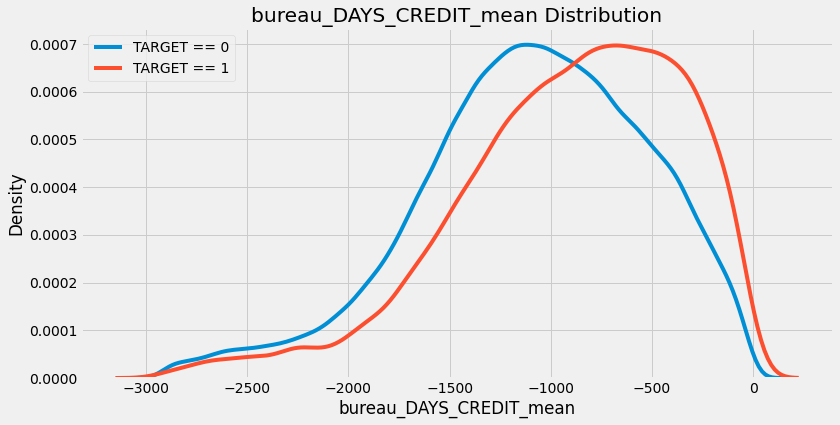

In [16]:
kde_target('bureau_DAYS_CREDIT_mean', train)

- 위 column은 고객이 신용관리국 신용등급을 신청한 날로부터 현 대출신청가지 걸린 기간은 몇 일인가? 에 관한 데이터이다.
-이것을 이전 대출을 받고나서 'Home Credit'에서 대출을 받기전까지 걸린 일수로 해석
- 마이너스 수치가 크다: 이전 대출이 이루어진 시점이 더 오래됐음
- 이 변수들과 Target이 양의 상관관계를 갖는다는 것은 더 오래된 과거에 대출을 신청했던 고객들은 'Home Credi'에서 대출을 상환할 가능성이 높다는 것을 의미
- 그러나 상관관계가 약하기 때문에 노이즈일 가능성도 있음


**다중비교문제(The Multiple Comparisons Problem)**
- 변수가 매우 많을 때는, 다중비교문제로 알려진 우연에 의해 변수들이 목표값에 대해 연관성을 가질 것으로 기대할 수 있다.
- 수백 개의 특성들을 만들 수 있지만, 몇개의 경우 그저 데이터 안의 랜덤하게 있는 노이즈값들에 의해 목표값과 연관성을 가지는 것처럼 보일 수 있다.
- 이러한 변수들은 훈련 데이터 상에서는 목표값과 관련성이 있는 것처럼 보이지만, 관련성들이 테스트 데이터까지 일반화될 수 없기 때문에 모델에 있어 오버피팅(과적합)을 야기할 수 있다.
- 그렇기에 Feature들을 만드는 것은 많은 고려가 필요하다.
 - 여기서 다중비교문제란 하 가지 통계적 사실에 대해, 가설을 많이 세울수록 우연에 의해 가설을 충족 시킬 결과를 얻을 확률이 높아지는 문제를 말한다.
 - ex) 원숭이한테 타자를 치라고 하고, 유의미한 단어 문장들이 나올 때까지 프랑스어, 영어, 스페인어, 독일어 등등일 가설을 세운다면 언젠가는 원하는 결과가 나올 수 있는 것과 비슷

## 수치데이터의 대표값 연산을 위한 함수 생성(Function for Numeric Aggregations)
이전의 작업들을 요약하여, 수치데이터의 대표값 계산을 위한 함수를 생성
- 이 함수는 데이터 프레임 전체에 걸쳐 수치 데이터 column들의 대표값들을 계산하는 역할
- 추후 다른 데이터프레임에 같은 연산을 적용할 경우, 이 함수를 활용함

In [17]:
def agg_numeric(df, group_var, df_name):
  '''
  데이터 프레임안의 수치데이터에 한하여 대푯값들을 계산한다. 이것은 새로운 feature들을 만드는데 활용될 수 있다.

  파라미터
  -------
  df : 연산의 대상이 되는 데이터프레임
  group_var : 그룹화의 기순이 되는 column 
  df_name : column명을 재정의하는데 쓰이는 변수

  출력값
  -------
  agg(dataframe):
  모든 수치데이터 column들의 대표값들이 연산된 데이터프레임. 
  각각의 그룹화된 인스턴스들은 대표값(평균, 최소값, 최대값, 합계)들을 가짐
  또한 새롭게 생성된 feature들을 구분하기 위해 column들의 이름을 재정의
  '''

  # 그룹화 대상이 아닌 id들을 제거
  for col in df:
    if col != group_var and 'SK_ID' in col:
      df = df.drop(columns = col)

  group_ids = df[group_var]
  numeric_df = df.select_dtypes('number')
  numeric_df[group_var] = group_ids
  
  # 특정 변수들을 그룹화하고 대표값들을 계산
  agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min','sum']).reset_index()
  
  # 새로운 column 이름들을 생성
  columns = [group_var]

  # 변수에 따라 반복문을 실행
  for var in agg.columns.levels[0]:
    
    # id column은 생략
    if var !=group_var:
      # 대표값의 종류에 따라 반복문을 생성
      for stat in agg.columns.levels[1][:-1]:
        columns.append('%s_%s_%s' % (df_name, var, stat))

  agg.columns = columns
  return agg

In [18]:
bureau_agg_new = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg_new.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_count,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_DAYS_ENDDATE_FACT_count,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_ENDDATE_FACT_min,bureau_DAYS_ENDDATE_FACT_sum,bureau_AMT_CREDIT_MAX_OVERDUE_count,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_max,bureau_AMT_CREDIT_MAX_OVERDUE_min,bureau_AMT_CREDIT_MAX_OVERDUE_sum,bureau_CNT_CREDIT_PROLONG_count,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_min,bureau_CNT_CREDIT_PROLONG_sum,bureau_AMT_CREDIT_SUM_count,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_LIMIT_count,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_AMT_CREDIT_SUM_LIMIT_min,bureau_AMT_CREDIT_SUM_LIMIT_sum,bureau_AMT_CREDIT_SUM_OVERDUE_count,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,0,7,82.428571,1778.0,-1329.0,577.0,4,-825.500000,-544.0,-1328.0,-3302.0,0,NaN,NaN,NaN,0.000,7,0.0,0,0,0,7,207623.571429,378000.0,85500.0,1453365.000,7,85240.928571,373239.0,0.0,596686.5,6,0.00000,0.000,0.0,0.000,7,0.0,0.0,0.0,0.0,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,0,6,-349.000000,780.0,-1072.0,-2094.0,6,-697.500000,-36.0,-1185.0,-4185.0,5,1681.029,5043.645,0.0,8405.145,8,0.0,0,0,0,8,108131.945625,450000.0,0.0,865055.565,5,49156.200000,245781.0,0.0,245781.0,4,7997.14125,31988.565,0.0,31988.565,8,0.0,0.0,0.0,0.0,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,0,4,-544.500000,1216.0,-2434.0,-2178.0,3,-1097.333333,-540.0,-2131.0,-3292.0,4,0.000,0.000,0.0,0.000,4,0.0,0,0,0,4,254350.125000,810000.0,22248.0,1017400.500,4,0.000000,0.0,0.0,0.0,4,202500.00000,810000.000,0.0,810000.000,4,0.0,0.0,0.0,0.0,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,0,2,-488.500000,-382.0,-595.0,-977.0,2,-532.500000,-382.0,-683.0,-1065.0,1,0.000,0.000,0.0,0.000,2,0.0,0,0,0,2,94518.900000,94537.8,94500.0,189037.800,2,0.000000,0.0,0.0,0.0,2,0.00000,0.000,0.0,0.000,2,0.0,0.0,0.0,0.0,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,0,3,439.333333,1324.0,-128.0,1318.0,1,-123.000000,-123.0,-123.0,-123.0,1,0.000,0.000,0.0,0.000,3,0.0,0,0,0,3,219042.000000,568800.0,29826.0,657126.000,3,189469.500000,543087.0,0.0,568408.5,3,0.00000,0.000,0.0,0.000,3,0.0,0.0,0.0,0.0,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


함수가 제대로 작동하는 지 살펴보기 위해, 수작업으로 만든 데이터프레임과 비교

In [19]:
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_count,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_DAYS_ENDDATE_FACT_count,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_ENDDATE_FACT_min,bureau_DAYS_ENDDATE_FACT_sum,bureau_AMT_CREDIT_MAX_OVERDUE_count,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_max,bureau_AMT_CREDIT_MAX_OVERDUE_min,bureau_AMT_CREDIT_MAX_OVERDUE_sum,bureau_CNT_CREDIT_PROLONG_count,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_min,bureau_CNT_CREDIT_PROLONG_sum,bureau_AMT_CREDIT_SUM_count,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_LIMIT_count,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_AMT_CREDIT_SUM_LIMIT_min,bureau_AMT_CREDIT_SUM_LIMIT_sum,bureau_AMT_CREDIT_SUM_OVERDUE_count,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,0,7,82.428571,1778.0,-1329.0,577.0,4,-825.500000,-544.0,-1328.0,-3302.0,0,NaN,NaN,NaN,0.000,7,0.0,0,0,0,7,207623.571429,378000.0,85500.0,1453365.000,7,85240.928571,373239.0,0.0,596686.5,6,0.00000,0.000,0.0,0.000,7,0.0,0.0,0.0,0.0,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,0,6,-349.000000,780.0,-1072.0,-2094.0,6,-697.500000,-36.0,-1185.0,-4185.0,5,1681.029,5043.645,0.0,8405.145,8,0.0,0,0,0,8,108131.945625,450000.0,0.0,865055.565,5,49156.200000,245781.0,0.0,245781.0,4,7997.14125,31988.565,0.0,31988.565,8,0.0,0.0,0.0,0.0,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,0,4,-544.500000,1216.0,-2434.0,-2178.0,3,-1097.333333,-540.0,-2131.0,-3292.0,4,0.000,0.000,0.0,0.000,4,0.0,0,0,0,4,254350.125000,810000.0,22248.0,1017400.500,4,0.000000,0.0,0.0,0.0,4,202500.00000,810000.000,0.0,810000.000,4,0.0,0.0,0.0,0.0,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,0,2,-488.500000,-382.0,-595.0,-977.0,2,-532.500000,-382.0,-683.0,-1065.0,1,0.000,0.000,0.0,0.000,2,0.0,0,0,0,2,94518.900000,94537.8,94500.0,189037.800,2,0.000000,0.0,0.0,0.0,2,0.00000,0.000,0.0,0.000,2,0.0,0.0,0.0,0.0,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,0,3,439.333333,1324.0,-128.0,1318.0,1,-123.000000,-123.0,-123.0,-123.0,1,0.000,0.000,0.0,0.000,3,0.0,0,0,0,3,219042.000000,568800.0,29826.0,657126.000,3,189469.500000,543087.0,0.0,568408.5,3,0.00000,0.000,0.0,0.000,3,0.0,0.0,0.0,0.0,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


- 두 데이터프레임이 동등하게 생성됨
- 추후 이 함수를 **데이터프레임의 대표값들을 계산**하는 데 재사용할 수 있을 것. 
- 함수를 사용하면 일관된 결과를 얻을 수 있을 뿐아니라, 해야 할 일의 양을 줄일 수 있다.


**상관계수 함수 생성**  
목표값(TARGET)과 변수간 상관계수를 계산하기 위한 코드를 작성함


In [20]:
# 데이터 프레임상의 목표값(target)과의 상관계수를 계산하기 위한 함수
def target_corrs(df):
  # 상관관계를 저장하기 위한 리스트 생성
  corrs = []

  # column별로 반복문을 실행
  for col in df.columns:
    print(col)

    # target column은 생략
    if col != 'TARGET':
      # 목표값(target)과의 상관계수 계산
      corr = df['TARGET'].corr(df[col])
      # 튜플(tuple)로 리스트에 추가
      corrs.append((col, corr))

  # 상관계수들을 절대값 크기에 따라 정렬
  corrs = sorted(corrs, key = lambda x: abs(x[1]), revrse = True)

  return corrs

# 범주형 데이터(Categorical Values)
- 주로 문자열 데이터들로써, 이러한 데이터들에 대해서는 평균이나 최대치 등 통계를 활용하기 어렵다.
- 그 대신, 범주별로 값들의 갯수를 셀 것이다.
- 그 다음, 고객별 대출 횟수를 활용하여 값들을 정규화(고객별 대출 횟수의 합계를 1로하여 계산)




먼저, 데이터프레임의 범주형 column들에 한하여 one-hot 인코딩을 적용(dtype==object)


In [21]:
categorical = pd.get_dummies(bureau.select_dtypes('object'))
categorical['SK_ID_CURR'] = bureau['SK_ID_CURR']
categorical.head()

,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Cash loan (non-earmarked),CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,SK_ID_CURR
0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,215354
1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,215354
2,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,215354
3,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,215354
4,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,215354


In [22]:
categorical_grouped = categorical.groupby('SK_ID_CURR').agg(['sum', 'mean'])
categorical_grouped.head()

CREDIT_ACTIVE_Active            ... CREDIT_TYPE_Unknown type of loan     
                            sum      mean  ...                              sum mean
SK_ID_CURR                                 ...                                      
100001                        3  0.428571  ...                                0  0.0
100002                        2  0.250000  ...                                0  0.0
100003                        1  0.250000  ...                                0  0.0
100004                        0  0.000000  ...                                0  0.0
100005                        2  0.666667  ...                                0  0.0

[5 rows x 46 columns]

- sum: 고객별 해당 범주에 속한 대출의 총 횟수
- mean: 횟수를 정규화
- one-hot인코딩을 통해 이러한 수치들을 계삲는 과정을 편리하게 믄들어줌
 - column제목들을 정의할 때 사용했던 것과 비슷한 함수를 활용한다. 
 - multi-level index로 작성되어있는 column들을 다룰 것
 - 범주형 데이터가 속한 **column의 이름을 차용한 First level(level 0)을 따라 반복문**을 먼저 실행
 - 그 다음, 계산된 **통계치들을 따라 반복문을 한번 더** 실행
 - **level 0의 이름에 통계치의 종류를 합쳐** column 제목들을 재정의
 - ex) CREDIT_ACTIVE_Active가 level 0이고, sum이 level 1인 column은 CREDIT_ACTIVE_Active_count로 정의

In [23]:
categorical_grouped.columns.levels[0][:10]

Index(['CREDIT_ACTIVE_Active', 'CREDIT_ACTIVE_Bad debt',
       'CREDIT_ACTIVE_Closed', 'CREDIT_ACTIVE_Sold',
       'CREDIT_CURRENCY_currency 1', 'CREDIT_CURRENCY_currency 2',
       'CREDIT_CURRENCY_currency 3', 'CREDIT_CURRENCY_currency 4',
       'CREDIT_TYPE_Another type of loan', 'CREDIT_TYPE_Car loan'],
      dtype='object')

In [24]:
categorical_grouped.columns.levels[1]

Index(['sum', 'mean'], dtype='object')

In [25]:
group_var = 'SK_ID_CURR'

# 새로운 column 제목들을 저장하기 위한 리스트를 생성
columns = []

# 변수(원본 데이터프레임의 column name)에 따라 반복문을 실행
for var in categorical_grouped.columns.levels[0]:
    
    # 고객 id column은 생략
    if var != group_var:

      # 통계치의 종류에 따라 반복문을 실행
      for stat in ['count','count_norm']:

        # 새로운 column 제목을 정의
        columns.append('%s_%s' % (var, stat))

# column들을 재정의
categorical_grouped.columns = columns

categorical_grouped.head()

,CREDIT_ACTIVE_Active_count,CREDIT_ACTIVE_Active_count_norm,CREDIT_ACTIVE_Bad debt_count,CREDIT_ACTIVE_Bad debt_count_norm,CREDIT_ACTIVE_Closed_count,CREDIT_ACTIVE_Closed_count_norm,CREDIT_ACTIVE_Sold_count,CREDIT_ACTIVE_Sold_count_norm,CREDIT_CURRENCY_currency 1_count,CREDIT_CURRENCY_currency 1_count_norm,CREDIT_CURRENCY_currency 2_count,CREDIT_CURRENCY_currency 2_count_norm,CREDIT_CURRENCY_currency 3_count,CREDIT_CURRENCY_currency 3_count_norm,CREDIT_CURRENCY_currency 4_count,CREDIT_CURRENCY_currency 4_count_norm,CREDIT_TYPE_Another type of loan_count,CREDIT_TYPE_Another type of loan_count_norm,CREDIT_TYPE_Car loan_count,CREDIT_TYPE_Car loan_count_norm,CREDIT_TYPE_Cash loan (non-earmarked)_count,CREDIT_TYPE_Cash loan (non-earmarked)_count_norm,CREDIT_TYPE_Consumer credit_count,CREDIT_TYPE_Consumer credit_count_norm,CREDIT_TYPE_Credit card_count,CREDIT_TYPE_Credit card_count_norm,CREDIT_TYPE_Interbank credit_count,CREDIT_TYPE_Interbank credit_count_norm,CREDIT_TYPE_Loan for business development_count,CREDIT_TYPE_Loan for business development_count_norm,CREDIT_TYPE_Loan for purchase of shares (margin lending)_count,CREDIT_TYPE_Loan for purchase of shares (margin lending)_count_norm,CREDIT_TYPE_Loan for the purchase of equipment_count,CREDIT_TYPE_Loan for the purchase of equipment_count_norm,CREDIT_TYPE_Loan for working capital replenishment_count,CREDIT_TYPE_Loan for working capital replenishment_count_norm,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,7,1.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,4,0.500000,4,0.500000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,2,0.500000,2,0.500000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,2,1.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,2,0.666667,1,0.333333,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


- sum column은 총 횟수를 나타내며, count_norm column은 횟수를 정규화시킨 것
- 이제 이 데이터프레임을 훈련 데이터셋과 합침


In [26]:
train = train.merge(categorical_grouped, left_on = 'SK_ID_CURR', right_index = True, how = 'left')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,CREDIT_ACTIVE_Sold_count,CREDIT_ACTIVE_Sold_count_norm,CREDIT_CURRENCY_currency 1_count,CREDIT_CURRENCY_currency 1_count_norm,CREDIT_CURRENCY_currency 2_count,CREDIT_CURRENCY_currency 2_count_norm,CREDIT_CURRENCY_currency 3_count,CREDIT_CURRENCY_currency 3_count_norm,CREDIT_CURRENCY_currency 4_count,CREDIT_CURRENCY_currency 4_count_norm,CREDIT_TYPE_Another type of loan_count,CREDIT_TYPE_Another type of loan_count_norm,CREDIT_TYPE_Car loan_count,CREDIT_TYPE_Car loan_count_norm,CREDIT_TYPE_Cash loan (non-earmarked)_count,CREDIT_TYPE_Cash loan (non-earmarked)_count_norm,CREDIT_TYPE_Consumer credit_count,CREDIT_TYPE_Consumer credit_count_norm,CREDIT_TYPE_Credit card_count,CREDIT_TYPE_Credit card_count_norm,CREDIT_TYPE_Interbank credit_count,CREDIT_TYPE_Interbank credit_count_norm,CREDIT_TYPE_Loan for business development_count,CREDIT_TYPE_Loan for business development_count_norm,CREDIT_TYPE_Loan for purchase of shares (margin lending)_count,CREDIT_TYPE_Loan for purchase of shares (margin lending)_count_norm,CREDIT_TYPE_Loan for the purchase of equipment_count,CREDIT_TYPE_Loan for the purchase of equipment_count_norm,CREDIT_TYPE_Loan for working capital replenishment_count,CREDIT_TYPE_Loan for working capital replenishment_count_norm,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0,0.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.5,4.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.5,2.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,

In [27]:
train.shape

(307511, 229)

In [28]:
train.iloc[:10, 123:]

,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_count,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_DAYS_ENDDATE_FACT_count,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_ENDDATE_FACT_min,bureau_DAYS_ENDDATE_FACT_sum,bureau_AMT_CREDIT_MAX_OVERDUE_count,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_max,bureau_AMT_CREDIT_MAX_OVERDUE_min,bureau_AMT_CREDIT_MAX_OVERDUE_sum,bureau_CNT_CREDIT_PROLONG_count,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_min,bureau_CNT_CREDIT_PROLONG_sum,bureau_AMT_CREDIT_SUM_count,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_sum,...,CREDIT_ACTIVE_Sold_count,CREDIT_ACTIVE_Sold_count_norm,CREDIT_CURRENCY_currency 1_count,CREDIT_CURRENCY_currency 1_count_norm,CREDIT_CURRENCY_currency 2_count,CREDIT_CURRENCY_currency 2_count_norm,CREDIT_CURRENCY_currency 3_count,CREDIT_CURRENCY_currency 3_count_norm,CREDIT_CURRENCY_currency 4_count,CREDIT_CURRENCY_currency 4_count_norm,CREDIT_TYPE_Another type of loan_count,CREDIT_TYPE_Another type of loan_count_norm,CREDIT_TYPE_Car loan_count,CREDIT_TYPE_Car loan_count_norm,CREDIT_TYPE_Cash loan (non-earmarked)_count,CREDIT_TYPE_Cash loan (non-earmarked)_count_norm,CREDIT_TYPE_Consumer credit_count,CREDIT_TYPE_Consumer credit_count_norm,CREDIT_TYPE_Credit card_count,CREDIT_TYPE_Credit card_count_norm,CREDIT_TYPE_Interbank credit_count,CREDIT_TYPE_Interbank credit_count_norm,CREDIT_TYPE_Loan for business development_count,CREDIT_TYPE_Loan for business development_count_norm,CREDIT_TYPE_Loan for purchase of shares (margin lending)_count,CREDIT_TYPE_Loan for purchase of shares (margin lending)_count_norm,CREDIT_TYPE_Loan for the purchase of equipment_count,CREDIT_TYPE_Loan for the purchase of equipment_count_norm,CREDIT_TYPE_Loan for working capital replenishment_count,CREDIT_TYPE_Loan for working capital replenishment_count_norm,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
0,8.0,-874.000000,-103.0,-1437.0,-6992.0,8.0,0.0,0.0,0.0,0.0,6.0,-349.000000,780.0,-1072.0,-2094.0,6.0,-697.500000,-36.0,-1185.0,-4185.0,5.0,1681.029,5043.645,0.0,8405.145,8.0,0.0,0.0,0.0,0.0,8.0,108131.945625,450000.0,0.0,865055.565,5.0,49156.200000,245781.0,0.0,245781.0,...,0.0,0.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.500000,4.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,-1400.750000,-606.0,-2586.0,-5603.0,4.0,0.0,0.0,0.0,0.0,4.0,-544.500000,1216.0,-2434.0,-2178.0,3.0,-1097.333333,-540.0,-2131.0,-3292.0,4.0,0.000,0.000,0.0,0.000,4.0,0.0,0.0,0.0,0.0,4.0,254350.125000,810000.0,22248.0,1017400.500,4.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.500000,2.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,-867.000000,-408.0,-1326.0,-1734.0,2.0,0.0,0.0,0.0,0.0,2.0,-488.500000,-382.0,-595.0,-977.0,2.0,-532.500000,-382.0,-683.0,-1065.0,1.0,0.000,0.000,0.0,0.000,2.0,0.0,0.0,0.0,0.0,2.0,94518.900000,94537.8,94500.0,189037.800,2.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

## 범주형 데이터들을 처리하기 위한 함수 생성 (Function to Handle Categorical Variables)
- 범주형 데이터들을 처리하기 위한 함수를 만들 것
- agg_numeric 함수를 만들 때 했던 것과 같은 방식으로 데이터 프레임을 그룹화
-  그 다음 각각의 범주에 따라 counts와 normalized counts를 계산

In [29]:
def count_categorical(df, group_var, df_name):
  '''
  group_var에 대해 각 고유 범주들의 counts 및 normalized counts를 계산
  파라미터 (Parameters)
  ---------------------
  df (dataframe): 연산의 대상이되는 데이터프레임
  group_var (string): 그룹화(groupby)의 기준이되는 column
  df_name (string): column명을 재정의하는데 쓰이는 변수


  출력값(Returns)
  -------------------
  categorical : 데이터프레임
  group_var에 대해 각 고유 범주들의 counts 및 normalized counts의 값이 포함된 데이터프레임
  '''
  # 범주형 column들을 선택
  categorical = pd.get_dummies(df.select_dtypes('object'))
  # 확실히 id가 column에 있도록 지정
  categorical[group_var] = df[group_var]

  # group_var를 기준으로 그룹화하고 sum과 mean을 계산
  categorical = categorical.groupby(group_var).agg(['sum','mean'])

  column_names = []
  # level 0의 column들에 따라 반복문을 실행
  for var in categorical.columns.levels[0]:
    # level 1의 통계값들에 대해 반복문을 실행
    for stat in ['count','count_norm']:
      column_names.append('%s_%s_%s' % (df_name, var, stat))

  categorical.columns = column_names

  return categorical

In [30]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,bureau_CREDIT_CURRENCY_currency 2_count,bureau_CREDIT_CURRENCY_currency 2_count_norm,bureau_CREDIT_CURRENCY_currency 3_count,bureau_CREDIT_CURRENCY_currency 3_count_norm,bureau_CREDIT_CURRENCY_currency 4_count,bureau_CREDIT_CURRENCY_currency 4_count_norm,bureau_CREDIT_TYPE_Another type of loan_count,bureau_CREDIT_TYPE_Another type of loan_count_norm,bureau_CREDIT_TYPE_Car loan_count,bureau_CREDIT_TYPE_Car loan_count_norm,bureau_CREDIT_TYPE_Cash loan (non-earmarked)_count,bureau_CREDIT_TYPE_Cash loan (non-earmarked)_count_norm,bureau_CREDIT_TYPE_Consumer credit_count,bureau_CREDIT_TYPE_Consumer credit_count_norm,bureau_CREDIT_TYPE_Credit card_count,bureau_CREDIT_TYPE_Credit card_count_norm,bureau_CREDIT_TYPE_Interbank credit_count,bureau_CREDIT_TYPE_Interbank credit_count_norm,bureau_CREDIT_TYPE_Loan for business development_count,bureau_CREDIT_TYPE_Loan for business development_count_norm,bureau_CREDIT_TYPE_Loan for purchase of shares (margin lending)_count,bureau_CREDIT_TYPE_Loan for purchase of shares (margin lending)_count_norm,bureau_CREDIT_TYPE_Loan for the purchase of equipment_count,bureau_CREDIT_TYPE_Loan for the purchase of equipment_count_norm,bureau_CREDIT_TYPE_Loan for working capital replenishment_count,bureau_CREDIT_TYPE_Loan for working capital replenishment_count_norm,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,7,1.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,4,0.500000,4,0.500000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,2,0.500000,2,0.500000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,2,1.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,2,0.666667,1,0.333333,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


## 다른 데이터프레임에 대해 적용 (Applying Operations to another dataframe)
- 이제 'bureau balance' 데이터프레임을 활용
- 이 데이터프레임은 월별 각 고객의 과거 타 금융기관 대출 데이터를 포함
- 고객들의 ID인 SK_ID_CURR에 따라 그룹화하기보다, 이전 대출의 ID인 SK_ID_BUREAU를 활용하여 1차 그룹화
-그룹화한 데이터프레임은 각각의 대출에 대한 정보를 행별로 포함
- 그 다음, SK_ID_CURR을 활용하여 그룹화한 뒤, 각 고객별 대출의 대표값(aggreation)들을 계산
- 최종 산출물은 각각의 행에 고객별로 대출에 대한 대표값들을 포함

In [31]:
# 'bureau blance' 데이터 불러오기
bureau_balance = pd.read_csv(GCS_DS_PATH+'/bureau_balance.csv')
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


각각의 대출별 상태(status)의 갯수

In [32]:
# 각각의 이전 대출에 대해 상태의 갯수를 파악
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


- 이제, 수치형(numeric) column을 다룸
-  MONTHS_BALACE : 신청일을 기준 남은 개월 수
- 추후 time variable로 활용

In [33]:
# 각각의 'SK_ID_CURR'별 대표값들을 계산
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


- 위의 데이터프레임들은 각각의 대출에 대해 계산한 것
- 이제 이것을 가각의 고객별로 계산
- 이를 위해 먼저 데이터 프레임을 합치고, 그 다음 모든 수치형(numeric) 데이터에 한하여 대표값들을 다시 계산
- SK_ID_CURR을 기준으로 그룹화


In [34]:
# 대출을 기준으로 데이터프레임을 그룹화
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')
# SK_ID_CURR을 포함하여 병합
bureau_by_loan = bureau_by_loan.merge(bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], on = 'SK_ID_BUREAU', how = 'left')
bureau_by_loan.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm,SK_ID_CURR
0,5001709,97,-48.0,0,-96,-4656,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402,NaN
1,5001710,83,-41.0,0,-82,-3403,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446,162368.0
2,5001711,4,-1.5,0,-3,-6,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000,162368.0
3,5001712,19,-9.0,0,-18,-171,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000,162368.0
4,5001713,22,-10.5,0,-21,-231,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000,150635.0


In [35]:
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')
bureau_balance_by_client.head()

,SK_ID_CURR,client_bureau_balance_MONTHS_BALANCE_count_count,client_bureau_balance_MONTHS_BALANCE_count_mean,client_bureau_balance_MONTHS_BALANCE_count_max,client_bureau_balance_MONTHS_BALANCE_count_min,client_bureau_balance_MONTHS_BALANCE_count_sum,client_bureau_balance_MONTHS_BALANCE_mean_count,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_mean_max,client_bureau_balance_MONTHS_BALANCE_mean_min,client_bureau_balance_MONTHS_BALANCE_mean_sum,client_bureau_balance_MONTHS_BALANCE_max_count,client_bureau_balance_MONTHS_BALANCE_max_mean,client_bureau_balance_MONTHS_BALANCE_max_max,client_bureau_balance_MONTHS_BALANCE_max_min,client_bureau_balance_MONTHS_BALANCE_max_sum,client_bureau_balance_MONTHS_BALANCE_min_count,client_bureau_balance_MONTHS_BALANCE_min_mean,client_bureau_balance_MONTHS_BALANCE_min_max,client_bureau_balance_MONTHS_BALANCE_min_min,client_bureau_balance_MONTHS_BALANCE_min_sum,client_bureau_balance_MONTHS_BALANCE_sum_count,client_bureau_balance_MONTHS_BALANCE_sum_mean,client_bureau_balance_MONTHS_BALANCE_sum_max,client_bureau_balance_MONTHS_BALANCE_sum_min,client_bureau_balance_MONTHS_BALANCE_sum_sum,client_bureau_balance_STATUS_0_count_count,client_bureau_balance_STATUS_0_count_mean,client_bureau_balance_STATUS_0_count_max,client_bureau_balance_STATUS_0_count_min,client_bureau_balance_STATUS_0_count_sum,client_bureau_balance_STATUS_0_count_norm_count,client_bureau_balance_STATUS_0_count_norm_mean,client_bureau_balance_STATUS_0_count_norm_max,client_bureau_balance_STATUS_0_count_norm_min,client_bureau_balance_STATUS_0_count_norm_sum,client_bureau_balance_STATUS_1_count_count,client_bureau_balance_STATUS_1_count_mean,client_bureau_balance_STATUS_1_count_max,client_bureau_balance_STATUS_1_count_min,...,client_bureau_balance_STATUS_4_count_count,client_bureau_balance_STATUS_4_count_mean,client_bureau_balance_STATUS_4_count_max,client_bureau_balance_STATUS_4_count_min,client_bureau_balance_STATUS_4_count_sum,client_bureau_balance_STATUS_4_count_norm_count,client_bureau_balance_STATUS_4_count_norm_mean,client_bureau_balance_STATUS_4_count_norm_max,client_bureau_balance_STATUS_4_count_norm_min,client_bureau_balance_STATUS_4_count_norm_sum,client_bureau_balance_STATUS_5_count_count,client_bureau_balance_STATUS_5_count_mean,client_bureau_balance_STATUS_5_count_max,client_bureau_balance_STATUS_5_count_min,client_bureau_balance_STATUS_5_count_sum,client_bureau_balance_STATUS_5_count_norm_count,client_bureau_balance_STATUS_5_count_norm_mean,client_bureau_balance_STATUS_5_count_norm_max,client_bureau_balance_STATUS_5_count_norm_min,client_bureau_balance_STATUS_5_count_norm_sum,client_bureau_balance_STATUS_C_count_count,client_bureau_balance_STATUS_C_count_mean,client_bureau_balance_STATUS_C_count_max,client_bureau_balance_STATUS_C_count_min,client_bureau_balance_STATUS_C_count_sum,client_bureau_balance_STATUS_C_count_norm_count,client_bureau_balance_STATUS_C_count_norm_mean,client_bureau_balance_STATUS_C_count_norm_max,client_bureau_balance_STATUS_C_count_norm_min,client_bureau_balance_STATUS_C_count_norm_sum,client_bureau_balance_STATUS_X_count_count,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_sum,client_bureau_balance_STATUS_X_count_norm_count,client_bureau_balance_STATUS_X_count_norm_mean,client_bureau_balance_STATUS_X_count_norm_max,client_bureau_balance_STATUS_X_count_norm_min,client_bureau_balance_STATUS_X_count_norm_sum
0,100001.0,7,24.571429,52,2,172,7,-11.785714,-0.5,-25.5,-82.5,7,0.0,0,0,0,7,-23.571429,-1,-51,-165,7,-400.000000,-1,-1326,-2800,7,4.428571,12,1,31.0,7,0.336651,1.000000,0.019231,2.356557,7,0.142857,1,0,...,7,0.0,0,0,0,7,0.0,0.0,0.0,0.0,7,0.0,0,0,0.0,7,0.0,0.0,0.0,0.0,7,15.714286,44,0,110.0,7,0.441240,0.966667,0.000000,3.088683,7,4.285714,9,0,30.0,7,0.214590,0.500000,0.0,1.502129
1,100002.0,8,13.750000,22,4,110,8,-21.875000,-1.5,-39.5,-175.0,8,-15.5,0,-3

종합. 이 단계에서는 bureau_balance데이터프레임에 대해 다음과 같은 과정
- 각각의 대출에 대해 수치형(numeric) 대표값들을 계산
- 각각의 대출에 대해 범주형(categorical) 데이터들의 갯수를 파악 
- 각각의 대출에 대한 대표값들과 갯수를 병합
- 각 고객별로 3의 결과에 대한 수치형 대표값들을 계산

최종 데이터프레임은 각 고객에 대한 개별 행으로 구성  
각 행은 이전 모든 대출들의 월별 정보들의 통계치들로 구성
- 몇몇 변수들은 약간 헷갈림
- ex1) client_bureau_balance_MONTHS_BALANCE_mean_mean : 각각의 대출에 대한 MONTHS_BALANCE의 평균값을 계산, 그 다음 클라이언트별 대출의 평균값을 계산
- ex2)
client_bureau_balance_STATUS_X_count_norm_sum : 각각의 대출에 대해 STATUS == x 인것의 빈도를 총 STATUS 수로 나눈 다음, 개별 클라이언트별로 그 수를 합산

- 최종 데이터프레임에 모든 결과를 합치기 전까지는 상관계수(correlation)를 계산하지 않음



# 생성된 함수의 병합 (Putting the Functions Together)
- 모든 변수들을 초기화한 뒤, 생성된 함수들을 사용하여 처음부터 만듦
- 반복해야하는 작업 공정에서 함수를 활용했을 때의 좋음

In [36]:
# 오래된 오브젝트들(objects)을 제거함으로써 메모리를 확보
import gc
gc.enable()

del train, bureau, bureau_balance, bureau_agg, bureau_agg_new, bureau_balance_agg, bureau_balance_counts, bureau_by_loan, bureau_balance_by_client, bureau_counts
gc.collect()

8834

In [37]:
# 모든 데이터프레임의 새 복사본들을 생성

train = pd.read_csv(GCS_DS_PATH+'/application_train.csv')
bureau = pd.read_csv(GCS_DS_PATH+'/bureau.csv')
bureau_balance = pd.read_csv(GCS_DS_PATH+'/bureau_balance.csv')

Bureau 데이터프레임 내 범주형 데이터의 갯수 세기

In [38]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,bureau_CREDIT_CURRENCY_currency 2_count,bureau_CREDIT_CURRENCY_currency 2_count_norm,bureau_CREDIT_CURRENCY_currency 3_count,bureau_CREDIT_CURRENCY_currency 3_count_norm,bureau_CREDIT_CURRENCY_currency 4_count,bureau_CREDIT_CURRENCY_currency 4_count_norm,bureau_CREDIT_TYPE_Another type of loan_count,bureau_CREDIT_TYPE_Another type of loan_count_norm,bureau_CREDIT_TYPE_Car loan_count,bureau_CREDIT_TYPE_Car loan_count_norm,bureau_CREDIT_TYPE_Cash loan (non-earmarked)_count,bureau_CREDIT_TYPE_Cash loan (non-earmarked)_count_norm,bureau_CREDIT_TYPE_Consumer credit_count,bureau_CREDIT_TYPE_Consumer credit_count_norm,bureau_CREDIT_TYPE_Credit card_count,bureau_CREDIT_TYPE_Credit card_count_norm,bureau_CREDIT_TYPE_Interbank credit_count,bureau_CREDIT_TYPE_Interbank credit_count_norm,bureau_CREDIT_TYPE_Loan for business development_count,bureau_CREDIT_TYPE_Loan for business development_count_norm,bureau_CREDIT_TYPE_Loan for purchase of shares (margin lending)_count,bureau_CREDIT_TYPE_Loan for purchase of shares (margin lending)_count_norm,bureau_CREDIT_TYPE_Loan for the purchase of equipment_count,bureau_CREDIT_TYPE_Loan for the purchase of equipment_count_norm,bureau_CREDIT_TYPE_Loan for working capital replenishment_count,bureau_CREDIT_TYPE_Loan for working capital replenishment_count_norm,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,7,1.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,4,0.500000,4,0.500000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,2,0.500000,2,0.500000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,2,1.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,2,0.666667,1,0.333333,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


Bureau 데이터프레임의 대표값 계산

In [39]:
bureau_agg = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var='SK_ID_CURR', df_name = 'bureau')
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_count,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_DAYS_ENDDATE_FACT_count,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_ENDDATE_FACT_min,bureau_DAYS_ENDDATE_FACT_sum,bureau_AMT_CREDIT_MAX_OVERDUE_count,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_max,bureau_AMT_CREDIT_MAX_OVERDUE_min,bureau_AMT_CREDIT_MAX_OVERDUE_sum,bureau_CNT_CREDIT_PROLONG_count,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_min,bureau_CNT_CREDIT_PROLONG_sum,bureau_AMT_CREDIT_SUM_count,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_LIMIT_count,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_AMT_CREDIT_SUM_LIMIT_min,bureau_AMT_CREDIT_SUM_LIMIT_sum,bureau_AMT_CREDIT_SUM_OVERDUE_count,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,0,7,82.428571,1778.0,-1329.0,577.0,4,-825.500000,-544.0,-1328.0,-3302.0,0,NaN,NaN,NaN,0.000,7,0.0,0,0,0,7,207623.571429,378000.0,85500.0,1453365.000,7,85240.928571,373239.0,0.0,596686.5,6,0.00000,0.000,0.0,0.000,7,0.0,0.0,0.0,0.0,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,0,6,-349.000000,780.0,-1072.0,-2094.0,6,-697.500000,-36.0,-1185.0,-4185.0,5,1681.029,5043.645,0.0,8405.145,8,0.0,0,0,0,8,108131.945625,450000.0,0.0,865055.565,5,49156.200000,245781.0,0.0,245781.0,4,7997.14125,31988.565,0.0,31988.565,8,0.0,0.0,0.0,0.0,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,0,4,-544.500000,1216.0,-2434.0,-2178.0,3,-1097.333333,-540.0,-2131.0,-3292.0,4,0.000,0.000,0.0,0.000,4,0.0,0,0,0,4,254350.125000,810000.0,22248.0,1017400.500,4,0.000000,0.0,0.0,0.0,4,202500.00000,810000.000,0.0,810000.000,4,0.0,0.0,0.0,0.0,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,0,2,-488.500000,-382.0,-595.0,-977.0,2,-532.500000,-382.0,-683.0,-1065.0,1,0.000,0.000,0.0,0.000,2,0.0,0,0,0,2,94518.900000,94537.8,94500.0,189037.800,2,0.000000,0.0,0.0,0.0,2,0.00000,0.000,0.0,0.000,2,0.0,0.0,0.0,0.0,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,0,3,439.333333,1324.0,-128.0,1318.0,1,-123.000000,-123.0,-123.0,-123.0,1,0.000,0.000,0.0,0.000,3,0.0,0,0,0,3,219042.000000,568800.0,29826.0,657126.000,3,189469.500000,543087.0,0.0,568408.5,3,0.00000,0.000,0.0,0.000,3,0.0,0.0,0.0,0.0,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


Bureau Balance 데이터프레임의 각 대출별 범주형 데이터 갯수 세기

In [40]:
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


Bureau Balance 데이터프레임의 각 대출별 대표값 계산

In [41]:
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


Bureau Balance 데이터프레임의 고객별 대표값 계산

In [42]:
# 각 대출별 데이터프레임 병합
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# SK_ID_CURR을 포함하여 병합
bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan, on = 'SK_ID_BUREAU', how = 'left')

# 고객별 대표값 계산
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')

## 계산된 특성(Feature)들을 훈련용 데이터와 병합

In [43]:
original_features = list(train.columns)
print('Original Number of Features: ', len(original_features))

Original Number of Features:  122


In [44]:
# breau 값 갯수 센 것과 병합
train = train.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')
# bureau 대표값 계산한 것과 병합
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
# 월별, 고객별 정보와 병합
train = train.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [45]:
new_features = list(train.columns)
print('Number of features using previous loans from other institutions data: ', len(new_features))

Number of features using previous loans from other institutions data:  333


# Feature Engineering 결과물 (Feature Engineering Outcomes)
- 이제 모든 작업을 마치고, 생성된 변수들을 살펴보고자 한다.
- **누락된 값의 비율, 목표값(Target)과의 상관계수, 변수간 상관계수**들을 살펴볼 것
- **collinear한 두 변수를 모두 갖는 것은 중복이기 때문에, 하나를 제거**해야 할때도 있음
- 또는 누락된 값들의 백분율을 활용하여 대부분의 값이 존재하지 않는 feature들을 제거할 수도 있음


Feature Selection
- Feature seletion은 모델 학습 및 일반화를 위해 변수들을 제거하는 과정
- 필요없고, 중복인 변수들을 제거하고, 중요한 변수들을 보존하는 것이 목적
- Feature Selection은 앞으로의 과정에 있어 중요한 초점이 될 것
- 'Curse of dimensionality (차원의 저주)'는 너무 많은 feature를 가질 때 생기는 문제
- 변수의 수가 증가함에 따라 변수와 목표값 사이의 상관관계를 학습하는데 필요한 데이터(datapoints)의 수는 기하급수적으로 증가


이 커널에서는 누락된 값들이 많거나, 다른 변수들에 대해 높은 상관관계들을 갖는 변수를 제거하는 방법을 사용  
그 다음, Gradient Boosting Machine과 Random Forest 모델로부터 반환된 Feature importance를 활용

## 누락된 값 (Missing Values)
- 데이터프레임 내의 누락된 값들은 중요한 고려사항
- 누락된 값이 많은 column은 삭제해야 할 수도 있음

In [46]:
# column별 누락된 값 갯수를 계산하기 위한 함수

def missing_values_table(df):
  # 전체 데이터프레임의 누락된 값 계산
  mis_val = df.isnull().sum()
  # 누락된 값의 백분율 계산
  mis_val_percent = 100 * df.isnull().sum() / len(df)
  # 표 작성
  mis_val_table = pd.concat([mis_val,mis_val_percent], axis=1)
  # column명 재정의
  mis_val_table_ren_columns = mis_val_table.rename(columns={
      0:'Missing Values', 1:'% of Total Values'
  })
  # 내림차순으로 표정렬
  mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)

  # 요약 정보 출력
  print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n" + 
         "There are " + str(mis_val_table_ren_columns.shape[0]) +" columns that have missing values.")
  
  # 데이터프레임 return
  return mis_val_table_ren_columns

In [47]:
missing_train = missing_values_table(train)
missing_train.head(10)

Your selected dataframe has 333 columns.
There are 278 columns that have missing values.


,Missing Values,% of Total Values
bureau_AMT_ANNUITY_min,227502,74.0
bureau_AMT_ANNUITY_max,227502,74.0
bureau_AMT_ANNUITY_mean,227502,74.0
client_bureau_balance_STATUS_4_count_min,215280,70.0
client_bureau_balance_STATUS_3_count_norm_mean,215280,70.0
client_bureau_balance_MONTHS_BALANCE_count_min,215280,70.0
client_bureau_balance_STATUS_4_count_max,215280,70.0
client_bureau_balance_STATUS_4_count_mean,215280,70.0
client_bureau_balance_STATUS_3_count_norm_min,215280,70.0
client_bureau_balance_STATUS_3_count_norm_max,215280,70.0


누락된 값의 비율이 높은 column이 여러 개 있음
- 누락된 값을 제거하는데 있어 기준이 되는 정해진 비율은 없으며, 문제에 따라 달라짐
- 여기서는 훈련데이터 및 테스트 데이터에 있어 90%의 이상의 누락값을 가진 column들을 제거

In [48]:
missing_train_vars = list(missing_train.index[missing_train['% of Total Values'] > 90])
len(missing_train_vars)

0

누락된 값들을 제거하기 앞서, 테스트 데이터에서의 누락된 값의 비율을 살펴봄  
그 다음 훈련 또는 테스트 데이터에 있어 90% 이상 누락된 값을 가진 column들을 제거
- 테스트데이터를 불러온 뒤 같은 연산들을 적용하고, 테스트 데이터안의 누락된 값들을 살펴봄

In [49]:
# 테스트 데이터 불러오기
test = pd.read_csv(GCS_DS_PATH+'/application_test.csv')

# bureau 데이터의 갯수들을 계산한 데이터프레임과 병합
test = test.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')
# bureau 데이터의 대표값들을 계산한 데이터프레임과 병합
test = test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
# bureau balance 데이터의 갯수들을 계산한 데이터프레임과 병합
test = test.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [50]:
print('Shape of Testing Data: ', test.shape)

Shape of Testing Data:  (48744, 332)


이제 훈련용 데이터와 테스트 데이터프레임이 같은 column들을 가지도록 맞춤
- 여기서는 문제 되지 않지만, one-hot 인코딩할 때에는 데이터프레임들이 동일한 column을 가지도록 맞춰야 함

In [51]:
train_labels = train['TARGET']

# 데이터프레임을 align. 'target' column은 제거됨
train, test = train.align(test, join = 'inner', axis = 1)

train['TARGET'] = train_labels

In [52]:
print('Training Data Shape: ', train.shape)
print('Testing Data Shape: ', test.shape)

Training Data Shape:  (307511, 333)
Testing Data Shape:  (48744, 332)


In [53]:
missing_test = missing_values_table(test)
missing_test.head(10)

Your selected dataframe has 332 columns.
There are 275 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,33495,68.7
COMMONAREA_MODE,33495,68.7
COMMONAREA_AVG,33495,68.7
NONLIVINGAPARTMENTS_MEDI,33347,68.4
NONLIVINGAPARTMENTS_AVG,33347,68.4
NONLIVINGAPARTMENTS_MODE,33347,68.4
FONDKAPREMONT_MODE,32797,67.3
LIVINGAPARTMENTS_MEDI,32780,67.2
LIVINGAPARTMENTS_MODE,32780,67.2
LIVINGAPARTMENTS_AVG,32780,67.2


In [54]:
missing_test_vars = list(missing_test.index[missing_test['% of Total Values'] > 90])
len(missing_test_vars)

0

In [55]:
missing_columns = list(set(missing_test_vars + missing_train_vars))
print('There are %d columns with more than 90%% missing in either the training or testing data.' % len(missing_columns))

There are 0 columns with more than 90% missing in either the training or testing data.


In [56]:
# Drop the missing columns
train = train.drop(columns = missing_columns)
test = test.drop(columns = missing_columns)

90% 이상 누락된 값을 가진 column들이 없기 때문에, 이번에는 어떠한 column들도 제거되지 않음  

다른방법 적용해야 함
- 이 시점에서 훈련용 데이터와 테스트용 데이터들을 저장
- 누락된 값들을 제거하기 위해, 다른 비율을 설정하고, 결과물을 비교해보는 것도 좋은 방법

In [57]:
train.to_csv('train_bureau_raw.csv', index = False)
test.to_csv('test_bureau_raw.csv', index = False)

## 상관계수 (Correlations)
목표값(target)과 변수(variable)들간 상관계수

In [58]:
# 데이터프레임상에서 모든 상관계수들을 계산
corrs = train.corr()

In [59]:
corrs = corrs.sort_values('TARGET', ascending = False)

# 상위 10개의 양의 상관계수
pd.DataFrame(corrs['TARGET'].head(10))

,TARGET
TARGET,1.000000
bureau_DAYS_CREDIT_mean,0.089729
client_bureau_balance_MONTHS_BALANCE_min_mean,0.089038
DAYS_BIRTH,0.078239
bureau_CREDIT_ACTIVE_Active_count_norm,0.077356
client_bureau_balance_MONTHS_BALANCE_mean_mean,0.076424
bureau_DAYS_CREDIT_min,0.075248
client_bureau_balance_MONTHS_BALANCE_min_min,0.073225
client_bureau_balance_MONTHS_BALANCE_sum_mean,0.072606
bureau_DAYS_CREDIT_UPDATE_mean,0.068927


In [60]:
# 상위 10개의 음의 상관계수
pd.DataFrame(corrs['TARGET'].dropna().tail(10))

,TARGET
client_bureau_balance_MONTHS_BALANCE_count_min,-0.048224
client_bureau_balance_STATUS_C_count_norm_mean,-0.055936
client_bureau_balance_STATUS_C_count_max,-0.061083
client_bureau_balance_STATUS_C_count_mean,-0.062954
client_bureau_balance_MONTHS_BALANCE_count_max,-0.068792
bureau_CREDIT_ACTIVE_Closed_count_norm,-0.079369
client_bureau_balance_MONTHS_BALANCE_count_mean,-0.080193
EXT_SOURCE_1,-0.155317
EXT_SOURCE_2,-0.160472
EXT_SOURCE_3,-0.178919


상관계수가 높다는 것이 그 변수가 유용하다는 것을 의미하지는 않음
- 수백개의 변수들을 생성했을 경우에는, 그저 random noise 때문에 상관관계에 있는 것처럼 보일 수도 있다는 것을 명심해야 함
- 그래도 새롭게 생성된 몇몇 변수들은 유용할 것처럼 보임


학습된 모델로부터 Feature Importance를 살펴보도록 함
- 새롭게 생성된 변수들에 대한 kde 그래프 작성 

The correlation between client_bureau_balance_MONTHS_BALANCE_count_mean and the TARGET is -0.0802
Median value for loan that was not repaid = 19.3333
Median value for loan that was repaid =     25.1429


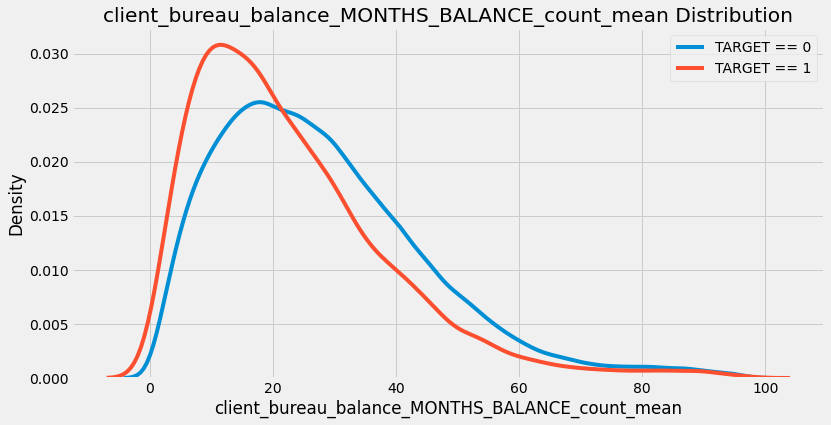

In [61]:
# 원문에는 client_bureau_balance_counts_mean 을 사용하고 있지만 해당 변수가 없어,
# 'client_bureau_balance_MONTHS_BALANCE_count_mean'으로 대체

kde_target(var_name='client_bureau_balance_MONTHS_BALANCE_count_mean', df=train)

각 고객의 대출별 월별 기록에 대한 평균
- 만약 고객의 과거 월별로 3, 4, 5의 기록을 갖고 있는 3개의 대출을 갖고 있다면, 이 변수에 있어 데이터값은 4
- 분산 그래프에 기초하여, 과거 월별 평균이 높은 사람들이 Home Credit에서의 대출에서 상환을 잘하는 것으로 보임
-  이 변수에 대해 너무 많이 분석하지는 않지만, 이 변수는 더 많은 신용 기록을 가지고 있는 고객들이 일반적으로 대출금을 상환할 가능성이 더 높다는 것을 나타낼 수 있음

The correlation between bureau_CREDIT_ACTIVE_Active_count_norm and the TARGET is 0.0774
Median value for loan that was not repaid = 0.5000
Median value for loan that was repaid =     0.3636


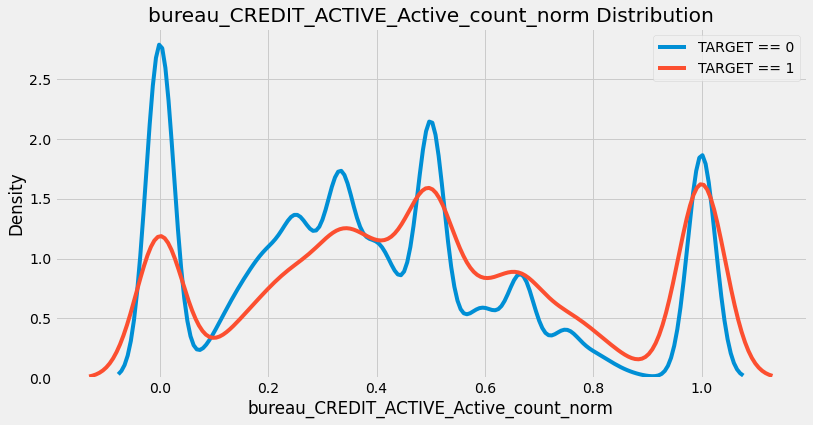

In [62]:
kde_target(var_name='bureau_CREDIT_ACTIVE_Active_count_norm', df=train)

이 변수의 경우 모든 곳에서 불규칙  
- 상관관계가 매우 약하기 때무에, 별도의 결론은 생각하지 않음

**Collinear Variables**  
목표값(target)과 변수간의 상관계수만 계산하는 것이 아닌, 각 변수간 상관계수까지 계산할 수 있음
- 이러한 방법은 제거해야 할 수도 있는 collinear 관계들을 가지는 변수들이 있는지 여부를 알려줌
- 0.8 이상의 상관계수를 가지는 변수들을 찾아보도록

In [63]:
# 임계치 설정
threshold = 0.8

# 상관계수가 높은 변수들을 저장하기 위한 빈 dictionary 생성
above_threshold_vars = {}

# 각각의 칼럼마다 임계치 이상의 변수들을 저장
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

- 높은 상관관계를 가지는 변수들의 쌍에 대해서, 하나의 변수만을 제거
- 아래의 코드는 각각의 쌍에서 한 개의 변수들만을 저장하는 set을 만드는 역할

In [64]:
# 제거할 column들 및 이미 검사된 column들의 목록을 저장위한 list 생성
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# columns 및 높은 상관관계를 가지는 columns를 따라 반복문 실행
for key, value in above_threshold_vars.items():
  # 이미 검사된 column 저장
  cols_seen.append(key)
  for x in value:
    if x == key:
      next
    else:
      # 각 쌍중 하나의 column만을 제거
      if x not in cols_seen:
        cols_to_remove.append(x)
        cols_to_remove_pair.append(key)

cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  134


In [65]:
train_corrs_removed = train.drop(columns = cols_to_remove)
test_corrs_removed = test.drop(columns = cols_to_remove)

print('Training Corrs Removed Shape: ', train_corrs_removed.shape)
print('Testing Corrs Removed Shape: ', test_corrs_removed.shape)

Training Corrs Removed Shape:  (307511, 199)
Testing Corrs Removed Shape:  (48744, 198)


In [66]:
train_corrs_removed.to_csv('train_bureau_corrs_removed.csv', index = False)
test_corrs_removed.to_csv('test_bureau_corrs_removed.csv', index = False)

훈련용 데이터와 테스트 데이터에서 column들을 제거
- olumn들을 제거한 데이터와 그렇지 않은 데이터로부터의 성능을 비교해보아야 함(앞서 저장한 csv 파일을 활용)

# 모델링

새롭게 생성된 데이터셋의 성능을 평가하기 위해, 머신러닝 사용
- 다른 커널에서 만들었던 함수를 활용해서, 다른 두 데이터셋(기존 데이터셋과 column들을 제거한 데이터셋)의 성능을 비교


모든 데이터셋에 대해, 아래와 같은 모델(정확히 같은 파라미터)를 사용
- control : application 데이터만 사용하여 얻은 결과
- test one : application 데이터와 더불어 bureau 및 bureau_balance 파일로부터 얻은 데이터를 사용하여 얻은 결과
- test two : application 데이터와 더불어 bureau 및 bureau_balance 파일로부터 얻은 데이터를 사용하되 높은 상관관계를 가지는 변수들을 제거하여 얻은 결과

In [67]:
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

import gc

import matplotlib.pyplot as plt

In [68]:
def model(features, test_feature, encoding = 'ohe', n_folds = 5):
  '''
  파라미터(Parameters)
  -------------------
    features (pd.DataFrame): 모델을 훈련하는데 있어 사용되는 feature들의 데이터프레임. 반드시 TARGET column을 포함하고 있어야 함.
    test_features (pd.DataFrame): 모델을 활용하여 예측하는데 사용되는 feature들의 데이터프레임.
    encoding (str, default='ohe'): 범주형 데이터(categorical variables)를 인코딩하는데 사용할 방식
      one hot encoding을 의미하는 'ohe' 또는 interger label encoding을 뜻하는 'le' 중 사용
    n_folds (int, default=5): cross validation에 활용할 folds의 갯수
    
    출력값(Return)
    --------------
    submission(pd.DataFrame):`SK_ID_CURR` 및 예측된 확률값인 `TARGET` 으로 구성된 데이터프레임
    feature_importances (pd.DataFrame): 모델로부터 얻어진 feature importance가 저장된 데이터프레임
    valid_metrics (pd.DataFrame): 각각의 fold 및 전체 데이터에 있어 training 및 validation 점수가 저장된 dataframe
  
  '''
  # id 추출
  train_ids = feature['SK_ID_CURR']
  test_ids = test_features['SK_ID_CURR']

  # 훈련단계에 사용되는 label 추출
  labels = features['TARGET']

  # id와 target값 제거
  features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
  test_features = test_features.drop(columns = ['SK_ID_CURR'])

  # One hot 인코딩
  if encoding == 'ohe':
    features = pd.get_dummies(features)
    test_features = pd.get_dummies(test_features)

    # 데이터프레임들의 column들을 일치시키기 
    features, test_features =features.align(test_features, join = 'inner', axis = 1)

    # 기록할 범주형 인덱스 없음
    cat_indices = 'auto'

  elif encoding == 'le':
    # label encoder 생성
    label_encoder = LabelEncoder()
    # 범주형 인덱스들을 저장하기 위한 리스트 생성
    cat_indices = []
    # 각 column별로 반복분 실행
    for i, col in enumerate(features):
      if features[col].dtype == 'object':
        # 범주형 데이터를 정수(integer)로 맵핑
        features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
        test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str).reshape((-1,)))
        # 범주형 인덱스들을 기록
        cat_indices.append(i)
    
  # 유효하지 않은 인코딩 방식이 입력되었을 때 오류처리
  else:
      raise ValueError('')
  print('Training Data Shape: ', features.shape)
  print('Testing Data Shape: ', test_features.shape) 
  
  # feature 이름들을 추출
  feature_names = list(features.columns)

  # np array로 변환
  features = np.array(features)
  test_features = np.array(test_features)

  # kfold 오브젝트 생성
  k_fold = KFold(n_splits=n_folds, shuffle = False, random_state=50)

  # feature importance를 저장하기 위한 array 생성
  feature_importances_values = np.zeros(len(feature_names))

  # 예측값을 저장하기 위한 array 생성
  test_predictions = np.zeros(test_features.shape[0])

  # 표본 외(out of fold) validation predictions 위한 array 생성
  out_of_fold = np.zeros(features.shape[0])

  # validation 및 training 점수를 저장하기 위한 리스트 생성
  valid_scores = []
  train_scores = []

  # 각 fold별 반복문 실행
  for train_indices, valid_indices in k_fold.split(features):

    # fold에서의 훈련용 데이터
    train_features, train_labels = feature[train_indices], labels[train_indices]

    # fold에서의 검증용 데이터
    valid_features, valid_labels = feature[valid_indices], labels[valid_indices]

    # 모델 생성
    model = lgb.LGBMClassifier(n_estimators=10000,objective = 'binary',
                               class_weight = 'balanced', learning_rate = 0.05,
                               reg_alpha = 0.1, reg_lambda = 0.1,
                               subsample = 0.8, n_jobs = -1, random_state = 50)

SyntaxError: ignored